In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [24]:
region = np.load("region_data.npz")
wind = np.load("wind_data.npz")
aq = np.load("aq_data.npz")

In [25]:
lon, lat = region['lon'], region['lat']
lon_wind, lat_wind = wind['lon'], wind['lat']
u, v = wind['u'], wind['v']
speed = wind['speed']
lon_aq, lat_aq = aq['lon'], aq['lat']
air_quality = aq['aq']

(28922, 3)


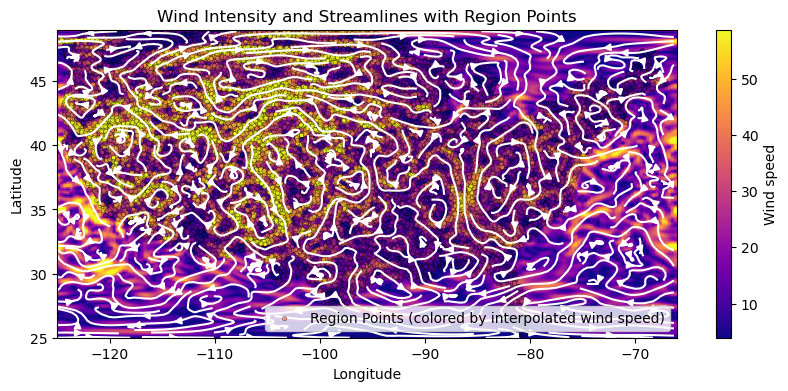

In [4]:
from scipy.interpolate import RegularGridInterpolator
lon1d = lon_wind[0, :]
lat1d = lat_wind[:, 0]

# Build interpolators
interp_u = RegularGridInterpolator(
    (lat1d, lon1d),
    u,
    bounds_error=False,
    fill_value=None
)

interp_v = RegularGridInterpolator(
    (lat1d, lon1d),
    v,
    bounds_error=False,
    fill_value=None
)

# Interpolate at region points
region_points = np.column_stack([lat, lon])

u_interp = interp_u(region_points)
v_interp = interp_v(region_points)

wind_speed = np.sqrt(u_interp**2 + v_interp**2)

X_wind = np.column_stack([u_interp, v_interp, wind_speed])


print(X_wind.shape)


plt.figure(figsize=(10,4))

im = plt.imshow(
    speed,
    origin="lower",
    extent=[lon_wind.min(), lon_wind.max(),
            lat_wind.min(), lat_wind.max()],
    aspect="auto",
    cmap="plasma",
    vmin=np.percentile(speed,5),
    vmax=np.percentile(speed,95),
)

plt.streamplot(
    lon_wind[0,::3],
    lat_wind[::3,0],
    u[::3,::3],
    v[::3,::3],
    color="white",
    density=2,
)

plt.scatter(lon, lat, c=X_wind[:,2], cmap="plasma", s=10, vmin=np.percentile(speed,5),alpha=0.7,marker='o',linewidths=0.3, edgecolors='black',
    vmax=np.percentile(speed,95), label="Region Points (colored by interpolated wind speed)")

plt.colorbar(im, label="Wind speed")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-125, -66)
plt.ylim(25, 49)
plt.title("Wind Intensity and Streamlines with Region Points")
plt.legend()

plt.show()

In [26]:
lon_aq.shape

(14017,)

In [27]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

lon_unique = np.unique(lon_aq)
lat_unique = np.unique(lat_aq)

aq_grid = np.full((len(lat_unique), len(lon_unique)), np.nan)
lat_idx = np.searchsorted(lat_unique, lat_aq)
lon_idx = np.searchsorted(lon_unique, lon_aq)
aq_grid[lat_idx, lon_idx] = air_quality

interp_aq = RegularGridInterpolator(
    (lat_unique, lon_unique),
    aq_grid,
    bounds_error=False,
    fill_value=None
)

aq_interp = interp_aq(np.column_stack([lat, lon]))

X_aq = aq_interp.reshape(-1,1)

print(X_aq.shape)


# Plotting with Plotly
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "geo"}, {"type": "geo"}]],
    subplot_titles=("Original Air Quality", "Interpolated Air Quality")
)

# Left: original pollution points
fig.add_trace(
    go.Scattergeo(
        lon=lon_aq,
        lat=lat_aq,
        mode="markers",
        marker=dict(
            size=5,
            color=air_quality,
            colorscale="Turbo",
            colorbar=dict(title="Air Quality", x=0.46),
            opacity=0.6,
        ),
        showlegend=False
    ),
    row=1, col=1
)

# Right: interpolated region points
fig.add_trace(
    go.Scattergeo(
        lon=lon,
        lat=lat,
        mode="markers",
        marker=dict(
            size=5,
            color=X_aq[:,0],
            colorscale="Turbo",
            colorbar=dict(title="Interpolated Air Quality", x=1.02),
            opacity=0.9,
            symbol="x"
        ),
        showlegend=False
    ),
    row=1, col=2
)

# Apply same map settings to both
fig.update_geos(
    scope="usa",
    showcountries=True,
    countrycolor="Black",
    showsubunits=True,
    subunitcolor="Blue",
    visible=False
)

fig.update_layout(
    width=2000,
    height=600,
    margin=dict(r=0, t=40, l=0, b=0)
)

fig.show()

(28922, 1)


In [6]:
# ============================================================
# Generate two DIFFERENT regression targets with interpretation
# ============================================================

import numpy as np


def generate_regression_targets(coords, Xw, Xa, seed=0):
    
    """
    Generates two interpretable region-level regression targets:

    Target 1: Respiratory Health Risk Index
        influenced by pollution exposure and wind-driven transport

    Target 2: Environmental Exposure Burden
        influenced by accumulated pollution and spatial environmental factors

    coords : (N,2) coordinates (lon, lat)
    Xw     : wind modality features
    Xa     : air quality modality features

    returns:
        targets : (N,2)
    """
    rng = np.random.default_rng(seed)

    N = coords.shape[0]


    # ========================================================
    # Smooth spatial field (shared latent geography)
    #
    # Interpretation:
    # underlying geographic vulnerability / ecosystem baseline
    # ========================================================

    C = coords - coords.mean(axis=0)
    W = rng.normal(size=(2, 32)) / 3.0
    b = rng.uniform(0, 2*np.pi, size=32)
    spatial = np.cos(C @ W + b) @ rng.normal(size=32)
    spatial = spatial - spatial.min()
    spatial = spatial / (spatial.max() + 1e-8)

    # ========================================================
    # Wind effect (Speed only)
    # ========================================================

    wind = Xw[:, -1]
    wind = wind / (wind.max() + 1e-8)


    # ========================================================
    # AQ effect
    # ========================================================

    aq = (Xa / (Xa.max() + 1e-8)).squeeze()

    # ========================================================
    # TARGET 1: Environmental Burden
    #
    # Interpretation:
    #
    # Environmental burden represents cumulative ecosystem exposure
    # driven directly by pollution and wind transport.
    # - AQ is the primary driver representing pollutant concentration
    # - Wind transports and redistributes pollutants across regions
    # - AQ×wind captures transported pollution amplifying accumulation
    # - Spatial term represents baseline geographic accumulation tendency
    # - Noise represents unobserved environmental variability
    # ========================================================

    noise1 = rng.gamma(shape=2.0, scale=0.05, size=N)
    environmental_burden = 2.5*aq + 2.5*wind + 1.0*aq*wind + 0.8*spatial + 0.2*noise1


    # ========================================================
    # TARGET 2: Respiratory Health Risk
    #
    # Interpretation:
    #
    # Respiratory health risk reflects physiological response to pollutant exposure.
    # - AQ contributes nonlinearly reflecting dose–response effects
    # - Environmental burden contributes as cumulative exposure history
    # - Wind contributes by influencing acute exposure conditions
    # - Spatial term represents baseline geographic and population vulnerability
    # - Threshold effect represents increased risk above elevated pollution levels
    # - Noise represents individual-level and demographic variability
    # ========================================================

    noise2 = rng.gamma(shape=2.0, scale=0.05, size=N)

    respiratory_risk = (
        0.5 * environmental_burden
        + 1.2 * aq**2
        + 1.0 * np.sqrt(np.abs(wind))
        + 0.1 * spatial
        + 1.0 * np.maximum(aq - np.percentile(aq, 70), 0)
        + 0.1*noise2
    )


    # ========================================================
    # Stack and standardize
    # ========================================================

    targets = np.stack([environmental_burden, respiratory_risk], axis=1)


    return targets

In [7]:
targets = generate_regression_targets(coords=np.column_stack([lon, lat]), Xw=X_wind, Xa=X_aq)
Y_e = targets[:,0]
Y_r = targets[:,1]


# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "geo"}, {"type": "geo"}]],
    subplot_titles=("Environmental Exposure", "Respiratory Risk")
)

# Left: original pollution points
fig.add_trace(
    go.Scattergeo(
        lon=lon,
        lat=lat,
        mode="markers",
        marker=dict(
            size=4,
            color=Y_e,
            colorscale="Turbo",
            colorbar=dict(title="Environmental Exposure", x=0.5),
            symbol="x"
        ),
        showlegend=False
    ),
    row=1, col=1
)

# Right: interpolated region points
fig.add_trace(
    go.Scattergeo(
        lon=lon,
        lat=lat,
        mode="markers",
        marker=dict(
            size=4,
            color=Y_r,
            colorscale="Turbo",
            colorbar=dict(title="Respiratory Risk", x=1),
        ),
        showlegend=False
    ),
    row=1, col=2
)

# Apply same map settings to both
fig.update_geos(
    scope="usa",
    showcountries=True,
    countrycolor="Black",
    showsubunits=True,
    subunitcolor="Blue",
    visible=False
)

fig.update_layout(
    width=2000,
    height=600,
    margin=dict(r=0, t=40, l=0, b=0)
)

fig.show()

In [11]:
state_labels = region["state_labels"]
edges = region["edges"]


# save new file with everything
np.savez(
    "region_graph_with_features_and_targets.npz",
    lon=lon,
    lat=lat,
    state_labels=state_labels,
    edges=edges,
    X_wind=X_wind,
    X_aq=X_aq,
    Y_r=Y_r,
    Y_e=Y_e
)

print("Saved region_graph_with_features_and_targets.npz")

Saved region_graph_with_features_and_targets.npz


In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

targets = generate_regression_targets(coords=np.column_stack([lon, lat]), Xw=X_wind, Xa=X_aq)
Y_e, Y_r = targets[:,0], targets[:,1]
vmin = min(Y_e.min(), Y_r.min())
vmax = max(Y_e.max(), Y_r.max())

fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "geo"}], [{"type": "geo"}]],
    subplot_titles=("Environmental Exposure", "Respiratory Health Risk"),
    vertical_spacing=0.08
)

fig.add_trace(go.Scattergeo(
    lon=lon, lat=lat, mode="markers", showlegend=False, 
    marker=dict(size=5, color=Y_e, colorscale="Turbo", cmin=vmin, cmax=vmax,
        colorbar=dict(tickfont=dict(size=14), len=0.4, y=0.78),
        symbol="x")
), row=1, col=1)

fig.add_trace(go.Scattergeo(
    lon=lon, lat=lat, mode="markers", showlegend=False,
    marker=dict(size=5, color=Y_r, colorscale="Turbo", cmin=vmin, cmax=vmax,
        colorbar=dict(tickfont=dict(size=14), len=0.4, y=0.22))
), row=2, col=1)

fig.update_geos(scope="usa", showcountries=True, countrycolor="black",
                showsubunits=True, subunitcolor="gray", visible=False)

fig.update_layout(
    width=900, height=1000,
    font=dict(size=18),
    margin=dict(l=10, r=10, t=60, b=10)
)
fig.update_annotations(font=dict(size=24))

fig.show()

fig.write_image("targets_vertical.pdf", scale=5)
fig.write_image("targets_vertical.png", scale=2)

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [2]:
A = np.load("region_graph_with_features_and_targets.npz")
B = np.load("region_graph_with_features_and_targets_test.npz")

In [3]:
A.keys()

KeysView(NpzFile 'region_graph_with_features_and_targets.npz' with keys: lon, lat, state_labels, edges, X_wind...)

In [3]:
lonA = A['lon']
lonB = B['lon']
latA = A['lat']
latB = B['lat']

print(np.nanmax(lonA-lonB), np.nanmin(lonA-lonB))
print(np.nanmax(latA-latB), np.nanmin(latA-latB))

0.0 0.0
0.0 0.0


In [7]:
np.array_equal(pollutionA, pollutionB, equal_nan=True)

True

In [4]:
state_labelsA = A['state_labels']
state_labelsB = B['state_labels']
print(np.nanmax(state_labelsA-state_labelsB), np.nanmin(state_labelsA-state_labelsB))

0 0


In [5]:
windA = A['X_wind']
windB = B['X_wind']
print(np.nanmax(windA-windB), np.nanmin(windA-windB))

0.0 0.0


In [6]:
pollutionA = A['X_aq']
pollutionB = B['X_aq']
print(np.nanmax(pollutionA-pollutionB), np.nanmin(pollutionA-pollutionB))

0.0 0.0


In [8]:
pollutionB

array([[0.15661271],
       [0.28431758],
       [0.33108721],
       ...,
       [0.45863799],
       [0.73343527],
       [0.71961424]])

In [9]:
YrB

array([1.45511301, 1.76675305, 1.26438414, ..., 1.83857089, 3.00993164,
       2.83312793])

In [8]:
YeA = A['Y_e']
YrA = A['Y_r']
YeB = B['Y_e']
YrB = B['Y_r']
print(np.nanmax(YeA-YeB), np.nanmin(YeA-YeB))
print(np.nanmax(YrA-YrB), np.nanmin(YrA-YrB))


0.0 0.0
0.0 0.0
